# **SONG RECOMMENDATION STYSTEM**

<a id="section-one"></a>
# **PROBLEM DEFINITION**


The objective of our project is to build a Song Recommender System utilizing a Spotify dataset. The aim is to design a model capable of suggesting songs to users, taking into account various song characteristics.

In [125]:
! pip install seaborn
! pip install altair


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [126]:
# General libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Metrics libraries
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

# Clustering libraries
from sklearn.cluster import KMeans

# Data procressing libraries
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

<a id="section-two"></a>
# **DATASET ANALYSIS**


In [127]:
# Read Dataset
data = pd.read_csv("data.csv")
data.shape

(2017, 17)

In [128]:
data.head()

,Unnamed: 0,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [129]:
# Fix Unnamed column's name
data = data.drop("Unnamed: 0", axis="columns")
# Drop unnecessary 'target' column
data.drop('target', axis=1, inplace=True)

In [130]:
# Drop duplicate values
data = data.drop_duplicates()

In [131]:
# Check for null values in the DataFrame
data.isnull().sum()

acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
song_title          0
artist              0
dtype: int64

In [132]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2009 entries, 0 to 2016
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      2009 non-null   float64
 1   danceability      2009 non-null   float64
 2   duration_ms       2009 non-null   int64  
 3   energy            2009 non-null   float64
 4   instrumentalness  2009 non-null   float64
 5   key               2009 non-null   int64  
 6   liveness          2009 non-null   float64
 7   loudness          2009 non-null   float64
 8   mode              2009 non-null   int64  
 9   speechiness       2009 non-null   float64
 10  tempo             2009 non-null   float64
 11  time_signature    2009 non-null   float64
 12  valence           2009 non-null   float64
 13  song_title        2009 non-null   object 
 14  artist            2009 non-null   object 
dtypes: float64(10), int64(3), object(2)
memory usage: 251.1+ KB


In [133]:
# Basic description of the dataset
data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
count,2009.000000,2009.000000,2.009000e+03,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000,2009.000000
mean,0.187710,0.618218,2.461865e+05,0.682004,0.133167,5.347437,0.190681,-7.074358,0.612743,0.092257,121.614624,3.968143,0.497320
std,0.259829,0.160989,8.201738e+04,0.210281,0.273127,3.649312,0.155387,3.758714,0.487245,0.089033,26.678969,0.256355,0.247118
min,0.000003,0.122000,1.604200e+04,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.034800
25%,0.009470,0.514000,1.999730e+05,0.564000,0.000000,2.000000,0.092200,-8.390000,0.000000,0.037500,100.189000,4.000000,0.296000
50%,0.063700,0.631000,2.290930e+05,0.716000,0.000075,6.000000,0.126000,-6.246000,1.000000,0.054900,121.427000,4.000000,0.493000
75%,0.265000,0.738000,2.698670e+05,0.846000,0.054000,9.000000,0.246000,-4.741000,1.000000,0.108000,137.644000,4.000000,0.692000
max,0.995000,0.984000,1.004627e+06,0.998000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000


In [134]:
# Print the size of the Dataset 
data.shape

(2009, 15)

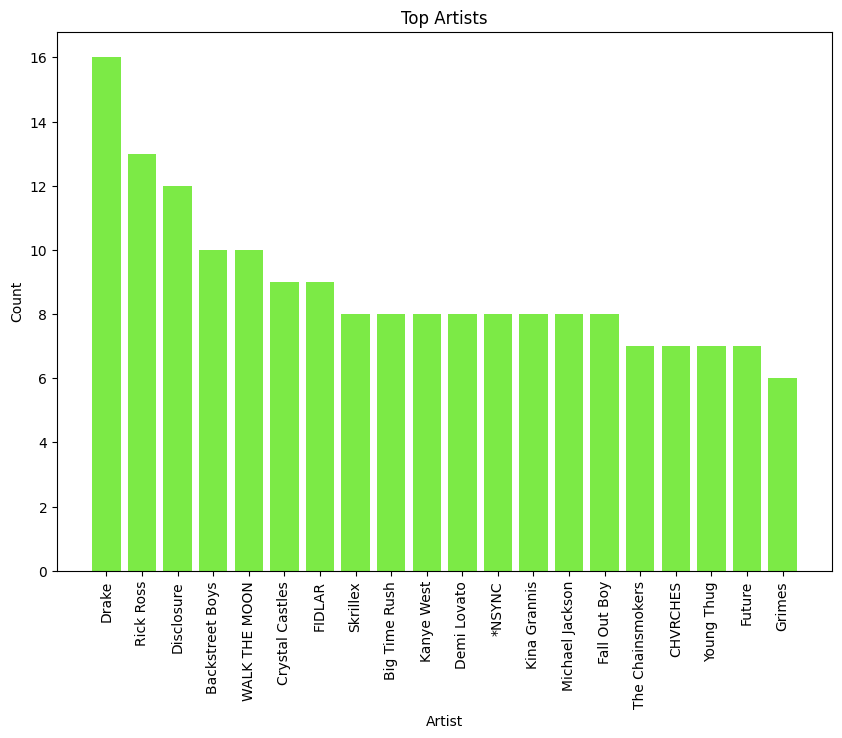

In [135]:
# Plot song count vs artist bar graph
values = data['artist'].value_counts().tolist()[:20]
names = list(dict(data['artist'].value_counts()).keys())[:20]

fig, ax = plt.subplots(figsize=(10, 7)) 
ax.bar(names, values, color="#7CEA46")

ax.set_title("Top Artists")
ax.set_xlabel("Artist")
ax.set_ylabel("Count")

plt.xticks(rotation=90)
plt.show()


In [136]:
# Categorical data
categorical_data = data.select_dtypes(include=['object'])
print("Categorical columns: ", categorical_data.columns.tolist())

# Numeric data
numeric_data = data.select_dtypes(include=['int64', 'float64'])
print("Numeric columns: ", numeric_data.columns.tolist())


Categorical columns:  ['song_title', 'artist']
Numeric columns:  ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence']


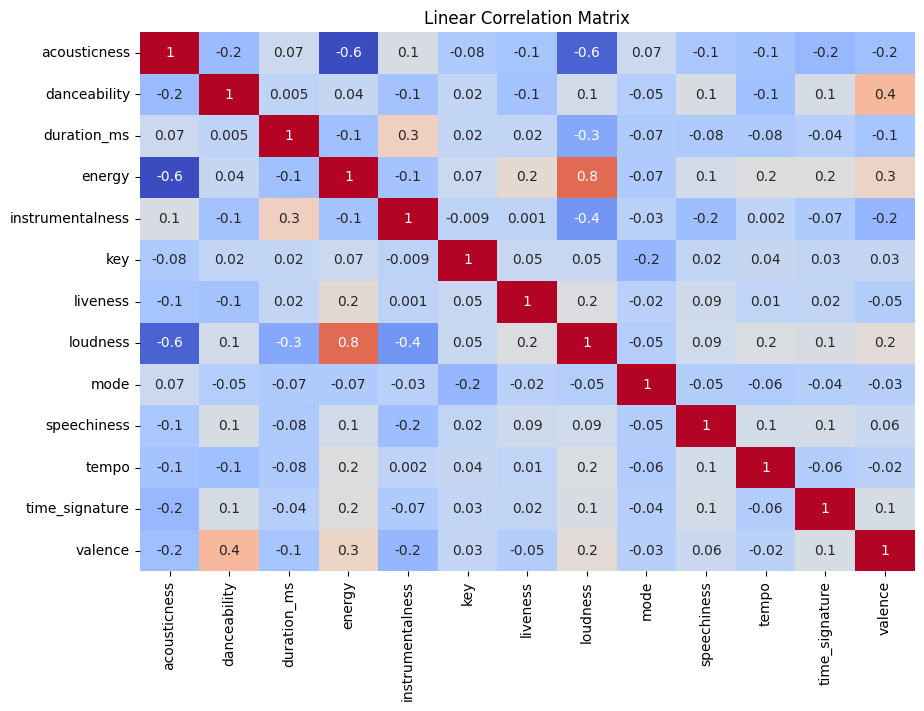

In [137]:
# Print Correlation Matrix to find the correlation between the attributes
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.1g', cmap="coolwarm", cbar=False)
plt.title('Linear Correlation Matrix')
plt.show()


We notice that the correlation between energy-loudness is really high and between acousticness-loudness and acousticness-energy is really low.

In [138]:
# Create new attributes
data['energy_loudness_ratio'] = data['energy'] / data['loudness']
numeric_data = pd.concat([numeric_data, data[['energy_loudness_ratio']]], axis=1)

data.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'song_title',
       'artist', 'energy_loudness_ratio'],
      dtype='object')

We print **Histograms** for all the numeric columns to check the values of each attribute

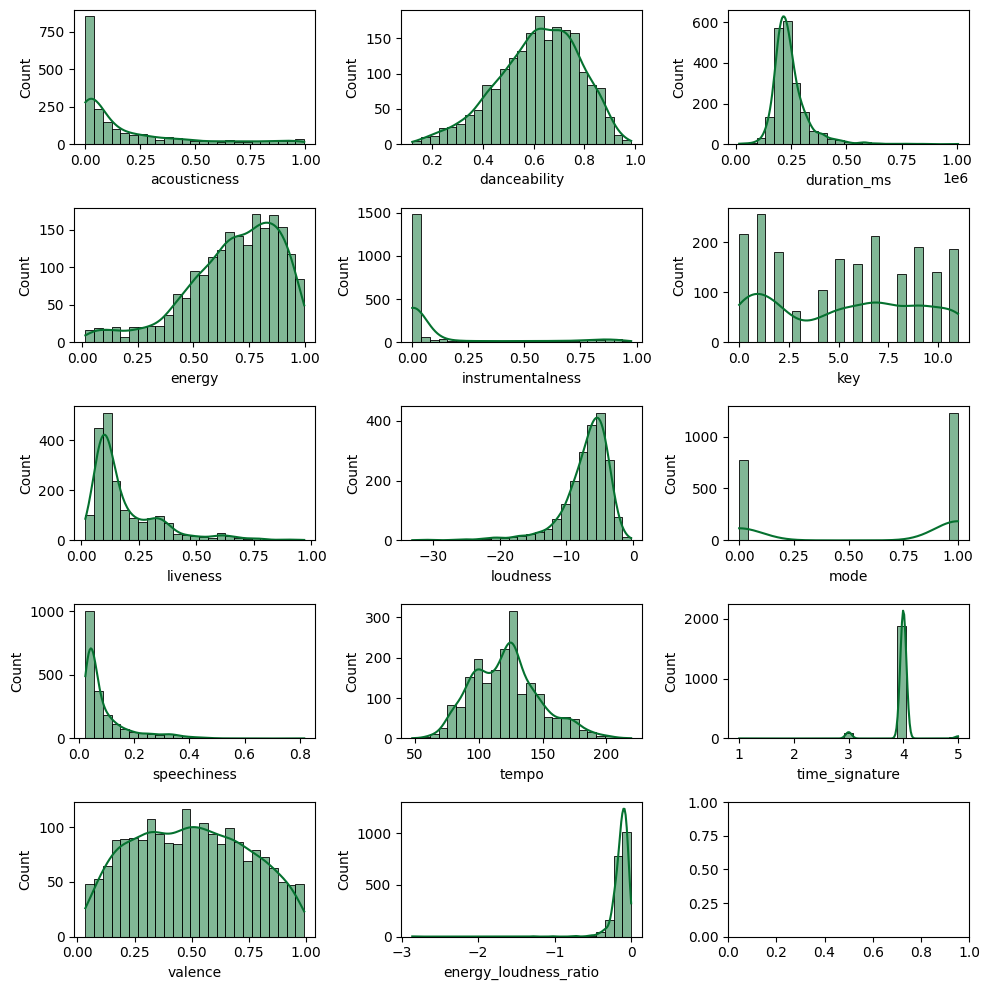

In [139]:
sns.set_palette("Greens_r")
num_cols = data.select_dtypes(include="number").columns
fig, axes = plt.subplots(5, 3, figsize=(10, 10))
axes = axes.flatten()
ax_no = 0
for col in num_cols:
    sns.histplot(data=data, x=col, bins=25, kde=True, ax=axes[ax_no])
    ax_no += 1
plt.tight_layout()
plt.show()

<a id="subsection2-two"></a>
## **Data Pre-Processing**

We clean the data so we feed only the important variables on the model

We notice that some attributes such as `mode`, `time_signature` don't have different values between the different songs on the dataset so they are not defined characteristics that we need for our analysis.

In [140]:
data.drop('mode', axis=1, inplace=True)
data.drop('time_signature', axis=1, inplace=True)

In [141]:
# Continuous Columns
continuous_cols = ['acousticness', 'danceability', 'duration_ms', 'energy','instrumentalness', 'liveness', 'loudness', 'speechiness',
            'tempo', 'valence']

# Discrete Columns
discrete_cols = ['key']

In [142]:
#Scale the continous data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(numeric_data[continuous_cols])

data[continuous_cols] = pd.DataFrame(scaled_features, columns=data[continuous_cols].columns)

# Save the scaler for test data
joblib.dump(scaler, 'scaler_model.joblib')

['scaler_model.joblib']

In [143]:
# Perform one-hot encoding
one_hot_encoded_data = pd.get_dummies(data, columns=discrete_cols, drop_first=True)
data = pd.concat([data.drop(columns=discrete_cols), one_hot_encoded_data], axis=1)

In [144]:
# Check for duplicate columns
duplicate_columns = data.columns[data.columns.duplicated()]
data = data.loc[:, ~data.columns.duplicated()]

data = data.dropna()

numeric_data = data.select_dtypes(include=[np.number])
numeric_data.columns

# Print the DataFrame after dropping duplicate columns
print(data.columns)

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'song_title', 'artist', 'energy_loudness_ratio', 'key_1',
       'key_2', 'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9',
       'key_10', 'key_11'],
      dtype='object')


In [145]:
# Feature Selection
n_components = 11

pca = PCA(n_components=n_components)
pca.fit(numeric_data)
explained_variance_ratio = pca.explained_variance_ratio_

top_components_indices = np.argsort(explained_variance_ratio)[::-1][:n_components]

sorted_attributes_pca = [numeric_data.columns[i] for i in top_components_indices]

pca_top_attributes = sorted_attributes_pca[:10]

final_attributes = pca_top_attributes[:10]

pca_data = numeric_data[final_attributes]

new_data_temp = pca_data.dropna()

pca_data.insert(10, 'song_title', data['song_title'])
pca_data.insert(11, 'artist', data['artist'])

new_data = pca_data.dropna()
new_data_temp.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,-0.683353,1.334474,-0.507172,-1.179686,-0.407484,-0.165313,-0.457888,3.805626,1.066550,-0.855352
1,0.043461,0.775291,0.984749,-1.536441,-0.465311,-0.345553,-0.885268,-0.144439,1.442258,0.367042
2,-0.590191,1.365539,-0.737583,-1.284334,-0.486830,-0.203936,-0.019597,2.210321,-1.746028,-1.312737
3,1.602569,-0.771781,-0.570430,-1.636332,1.380040,-0.633936,-2.171933,-0.743240,-1.317719,-1.082021
4,-0.029682,0.371437,1.789169,-0.575581,1.387364,1.598462,-1.217113,-0.256784,1.964185,1.646103


In [146]:
# Save processed dataset
new_data_temp.to_csv('SongDataset.csv', index=False) 

<a id="section-three"></a>
# **Model Development**

<a id="subsection3two-one"></a>
## **K-Means Clustering**

In [147]:
print(new_data_temp.columns)

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence'],
      dtype='object')


In [148]:
n_clusters = 5 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

new_data_temp.head()
cluster_labels_kmeans = kmeans.fit_predict(new_data_temp)

new_data['cluster_label_kmeans'] = cluster_labels_kmeans

joblib.dump(kmeans, 'kmeans_model.joblib')

centroids = kmeans.cluster_centers_
print(centroids)

[[-0.0452724   0.4513871  -0.19321544 -0.05550452 -0.42169944  0.12331668
   0.01755839  2.42245281  0.09859941  0.172399  ]
 [ 2.40692973 -1.0273151   0.57641944 -2.20026265  0.85205216 -0.23907311
  -2.1431406  -0.57354319 -0.39127319 -1.12938332]
 [-0.0662112   0.54767165 -0.13776763  0.05410613 -0.39641934 -0.27498849
   0.13744849 -0.28732145 -0.33122904  0.59634699]
 [-0.41921055 -0.68253947 -0.19873632  0.43381673 -0.36420753  0.36871206
   0.46293407 -0.20070063  0.50018652 -0.52719148]
 [-0.39635275  0.06268303  0.78943962  0.34658169  2.19651768  0.13652783
  -0.16523151 -0.29357958  0.12490785 -0.15735997]]


c:\Users\anubh\OneDrive\Desktop\ProJect\music recmmandation\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [149]:
# Save labelled dataset
new_data.to_csv('labelled.csv', index=False) 

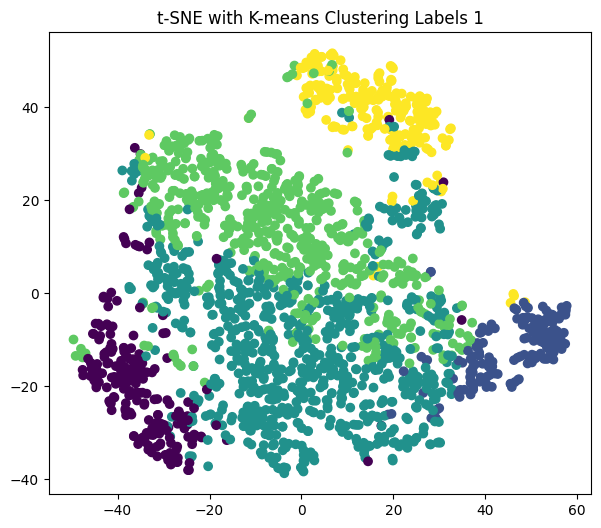

In [150]:
tsne = TSNE(n_components=2, random_state=42)
transformed_data = tsne.fit_transform(new_data.iloc[:, 0:10]) 

tsne_df = pd.DataFrame(data={
    'X': transformed_data[:, 0],
    'Y': transformed_data[:, 1],
    'Cluster_Kmeans': new_data['cluster_label_kmeans'],
})

plt.figure(figsize=(7, 6))
plt.scatter(tsne_df['X'], tsne_df['Y'], c=tsne_df['Cluster_Kmeans'], cmap='viridis')
plt.title('t-SNE with K-means Clustering Labels 1')
plt.show()

<a id="section-four"></a>
# **EVALUATION**

In [151]:
# Calculate Silhouette Coefficient kmeans
silhouette_score = metrics.silhouette_score(new_data.iloc[:, 0:10], new_data['cluster_label_kmeans'])
print(f'Silhouette Coefficient: {silhouette_score}')

# Calculate Calinski-Harabasz Index
calinski_harabasz_score = metrics.calinski_harabasz_score(new_data.iloc[:, 0:10], new_data['cluster_label_kmeans'])
print(f'Calinski-Harabasz Index: {calinski_harabasz_score}')

Silhouette Coefficient: 0.1570638719387712
Calinski-Harabasz Index: 320.4039942930642
